In [6]:
import pandas as pd
# 使用原始字符串表示路径（在引号前加r）
file_path = r"D:\code\py_work\CretaceousGalaxy\Course-risk_management_financial_institutions\second_task\基金数据.xlsx"

# 读取文件
excel_file = pd.ExcelFile(file_path)

# 获取所有表名
sheet_names = excel_file.sheet_names
sheet_names
import openpyxl
sheet_names = excel_file.sheet_names
sheet_names
# 获取指定工作表中的数据
df = excel_file.parse('file', skiprows=1)
# 查看数据的基本信息
print('数据基本信息：')
df.info()

# 查看数据集行数和列数
rows, columns = df.shape

if rows < 100 and columns < 20:
    # 短表数据（行数少于100且列数少于20）查看全量数据信息
    print('数据全部内容信息：')
    print(df.to_csv(sep='\t', na_rep='nan'))
else:
    # 长表数据查看数据前几行信息
    print('数据前几行内容信息：')
    print(df.head().to_csv(sep='\t', na_rep='nan'))
    import numpy as np
    from scipy.optimize import minimize

    # 计算日收益率
    returns = df[['纳斯达克ETF', '红利低波ETF', '黄金ETF']].pct_change().dropna()

    # 计算年化波动率（一年按 252 个交易日计算）
    volatility = returns.std() * np.sqrt(252)

    # 计算相关系数矩阵
    correlation_matrix = returns.corr()

    # 计算协方差矩阵
    covariance_matrix = returns.cov() * 252

    # 初始权重（等权重）
    initial_weights = np.array([1 / 3, 1 / 3, 1 / 3])

    # 投资组合总价值（元）
    portfolio_value = 1000000


    # 定义目标函数：最小化各资产边际 VaR 的差异
    def objective(weights):
        # 计算组合标准差
        portfolio_std = np.sqrt(weights @ covariance_matrix @ weights.T)
        # 计算各资产的边际 VaR
        marginal_var = weights * covariance_matrix @ weights.T / portfolio_std
        # 计算边际 VaR 的差异（目标是使其相等）
        return np.sum(np.square(marginal_var - marginal_var.mean()))


    # 约束条件：权重之和为 1
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]

    # 权重边界：非负
    bounds = [(0, None) for _ in range(len(initial_weights))]

    # 求解优化问题
    result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    optimal_weights = result.x

    # 计算各资产的投资金额
    allocation = optimal_weights * portfolio_value

    # 输出结果
    print("最优投资组合权重:")
    print(f"纳斯达克 ETF (513300.SH): {optimal_weights[0]:.4f}")
    print(f"红利低波 ETF (512890.SH): {optimal_weights[1]:.4f}")
    print(f"黄金 ETF (518880.SH): {optimal_weights[2]:.4f}")

    print("\n最优投资金额分配:")
    print(f"纳斯达克 ETF (513300.SH): {allocation[0]:.2f} 元")
    print(f"红利低波 ETF (512890.SH): {allocation[1]:.2f} 元")
    print(f"黄金 ETF (518880.SH): {allocation[2]:.2f} 元")


数据基本信息：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   日期       1080 non-null   datetime64[ns]
 1   纳斯达克ETF  1080 non-null   float64       
 2   红利低波ETF  1080 non-null   float64       
 3   黄金ETF    1080 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 33.9 KB
数据前几行内容信息：
	日期	纳斯达克ETF	红利低波ETF	黄金ETF
0	2020-11-05	1.013	0.66	3.965
1	2020-11-06	1.005	0.663	4.001
2	2020-11-09	1.03	0.673	3.99
3	2020-11-10	0.995	0.673	3.889
4	2020-11-11	0.983	0.677	3.881

最优投资组合权重:
纳斯达克 ETF (513300.SH): 0.2158
红利低波 ETF (512890.SH): 0.3157
黄金 ETF (518880.SH): 0.4685

最优投资金额分配:
纳斯达克 ETF (513300.SH): 215760.15 元
红利低波 ETF (512890.SH): 315693.06 元
黄金 ETF (518880.SH): 468546.79 元



最终组合价值: 1353632.1402410218
期间收益率: 35.363214024102184 %

权重变化统计:
       nasdaq_weight  dividend_weight  gold_weight
count      17.000000        17.000000    17.000000
mean        0.246925         0.325687     0.427388
std         0.024657         0.027777     0.036244
min         0.222041         0.288777     0.333333
25%         0.236141         0.306911     0.416805
50%         0.245598         0.319655     0.435336
75%         0.248310         0.336305     0.454081
max         0.333333         0.394434     0.471297


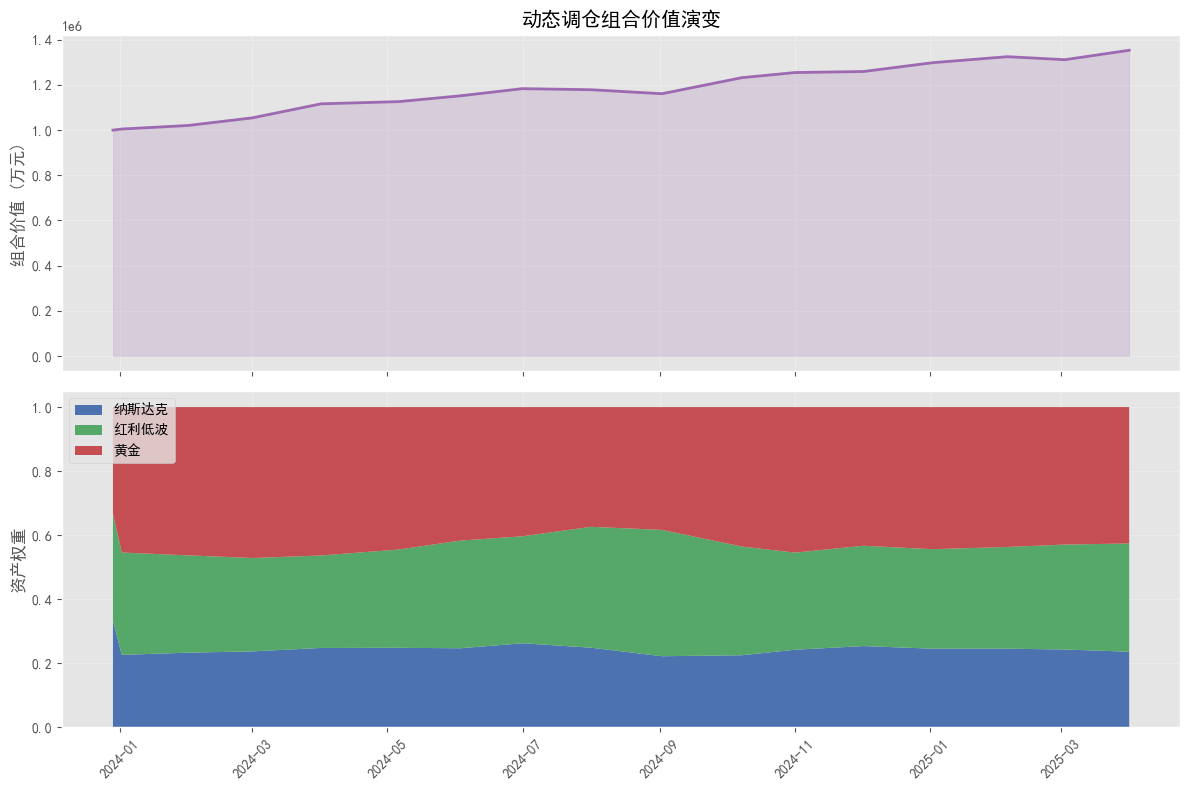

In [11]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from datetime import datetime, timedelta

# ================= 数据准备 =================
file_path = r"D:\code\py_work\CretaceousGalaxy\Course-risk_management_financial_institutions\second_task\基金数据.xlsx"
df = pd.read_excel(file_path, 
                 sheet_name='file', 
                 skiprows=1, 
                 parse_dates=['日期'],
                 index_col='日期').sort_index()

# ================= 参数设置 =================
start_date = '2023-12-29'  # 初始投资日期
end_date = '2025-04-18'    # 回测结束日期
initial_capital = 1e6      # 初始投资金额
lookback_window = 252      # 计算协方差的滚动窗口

# ================= 核心函数 =================
def calculate_weights(returns_data):
    """计算最优权重"""
    cov_matrix = returns_data.cov() * 252
    
    def objective(weights):
        port_std = np.sqrt(weights @ cov_matrix @ weights.T)
        marginal_var = weights * cov_matrix @ weights.T / port_std
        return np.sum(np.square(marginal_var - marginal_var.mean()))
    
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
    bounds = [(0, 1) for _ in range(3)]
    result = minimize(objective, [1/3]*3, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x if result.success else None

def get_trading_dates(start, end):
    """生成实际交易日调仓序列"""
    all_dates = df.loc[start:end].index
    rebalance_dates = []
    current_month = None
    
    for date in all_dates:
        if date.month != current_month:
            rebalance_dates.append(date)
            current_month = date.month
    return rebalance_dates[1:]  # 排除初始日期

# ================= 回测引擎 =================
def run_backtest():
    # 初始化持仓
    holdings = {
        'date': [pd.to_datetime(start_date)],
        'nasdaq_weight': [1/3],
        'dividend_weight': [1/3],
        'gold_weight': [1/3],
        'value': [initial_capital],
        'nasdaq_shares': [initial_capital/3 / df.loc[start_date, '纳斯达克ETF']],
        'dividend_shares': [initial_capital/3 / df.loc[start_date, '红利低波ETF']],
        'gold_shares': [initial_capital/3 / df.loc[start_date, '黄金ETF']]
    }
    
    rebalance_dates = get_trading_dates(start_date, end_date)
    
    for reb_date in rebalance_dates:
        try:
            # 获取当前价格
            prices = df.loc[reb_date, ['纳斯达克ETF', '红利低波ETF', '黄金ETF']]
            
            # 计算当前持仓价值
            prev = holdings['date'][-1]
            curr_values = [
                holdings['nasdaq_shares'][-1] * prices['纳斯达克ETF'],
                holdings['dividend_shares'][-1] * prices['红利低波ETF'],
                holdings['gold_shares'][-1] * prices['黄金ETF']
            ]
            total_value = sum(curr_values)
            
            # 计算历史收益率（滚动窗口）
            hist_data = df.loc[:reb_date].iloc[-lookback_window:]
            returns = hist_data.pct_change().dropna()
            
            if len(returns) < 50:
                raise ValueError("Insufficient historical data")
                
            # 计算新权重
            new_weights = calculate_weights(returns)
            if new_weights is None:
                raise RuntimeError("Optimization failed")
                
            # 计算新持仓份额
            new_shares = [
                (total_value * new_weights[0]) / prices['纳斯达克ETF'],
                (total_value * new_weights[1]) / prices['红利低波ETF'],
                (total_value * new_weights[2]) / prices['黄金ETF']
            ]
            
            # 更新记录
            holdings['date'].append(reb_date)
            holdings['value'].append(total_value)
            holdings['nasdaq_shares'].append(new_shares[0])
            holdings['dividend_shares'].append(new_shares[1])
            holdings['gold_shares'].append(new_shares[2])
            holdings['nasdaq_weight'].append(new_weights[0])
            holdings['dividend_weight'].append(new_weights[1])
            holdings['gold_weight'].append(new_weights[2])
            
        except Exception as e:
            print(f"{reb_date} 调仓失败: {str(e)}")
            # 继承上次持仓
            holdings['date'].append(reb_date)
            holdings['value'].append(total_value)  # 使用最后计算的总价值
            for key in ['nasdaq_shares', 'dividend_shares', 'gold_shares']:
                holdings[key].append(holdings[key][-1])
            for key in ['nasdaq_weight', 'dividend_weight', 'gold_weight']:
                holdings[key].append(holdings[key][-1])
    
    return pd.DataFrame(holdings)

# ================= 执行回测 =================
results = run_backtest()

# ================= 结果分析 =================
print("\n最终组合价值:", results['value'].iloc[-1])
print("期间收益率:", (results['value'].iloc[-1]/initial_capital-1)*100, "%")

print("\n权重变化统计:")
print(results[['nasdaq_weight', 'dividend_weight', 'gold_weight']].describe())

# ================= 可视化 =================
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# 价值曲线
ax[0].plot(results['date'], results['value'], color='#9D69B1', lw=2)
ax[0].set_ylabel('组合价值 (万元)')
ax[0].set_title('动态调仓组合价值演变')
ax[0].grid(True, alpha=0.3)
ax[0].fill_between(results['date'], results['value'], 
                 alpha=0.2, color='#9D69B1')

# 权重分布
colors = ['#4C72B0', '#55A868', '#C44E52']
labels = ['纳斯达克', '红利低波', '黄金']
ax[1].stackplot(results['date'],
               results['nasdaq_weight'],
               results['dividend_weight'],
               results['gold_weight'],
               colors=colors, labels=labels)
ax[1].set_ylabel('资产权重')
ax[1].legend(loc='upper left')
ax[1].grid(True, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()